In [1]:
from ScriptFiles import DataCleaning_and_Prediction as dc
from ScriptFiles import DataRead_and_PreClean as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
 

In [2]:
#############################################################################
### Function to plot Data profile in terms of fuelvoltage, Distance over time

def plotData_profiles(df):
    plt.rcParams['figure.figsize'] = [16, 12]

    #### 1. Checking order of Data, as per datetime
    plt.subplot(3,1,1)
    plt.plot(df.index, df.datetime, 'g.', markersize=1, linewidth=1);

    plt.subplot(3,1,2)
    plt.plot(df.index, df.fuelVoltage, 'g.', markersize=2, linewidth=1);

    plt.subplot(3,1,3)
    plt.plot(df.index, df.distance, 'g-', markersize=2, linewidth=1);
    plt.title("Cumulative Distance vs Time", fontsize=15)
    plt.show()

In [3]:
#######################################################
### Function to Plot theft Points over Cleaned Data

def plot_theftpts(cleanedDf , theftpts = [], xlim=[], ylim = []):

    plt.rcParams['figure.figsize'] = [20, 4]
    # plt.subplot(6,1,1)
    plt.plot(cleanedDf.index, cleanedDf.fuelVoltage, 'g.', markersize=2, linewidth=1);
    plt.plot(cleanedDf.index, cleanedDf.distance, 'b-', markersize=2, linewidth=1);
    plt.title("Initial Prediction theft Points - ZOOMED")
    if len(xlim) !=0:
        plt.xlim(xlim)
    if len(ylim)!=0:
        plt.ylim(ylim)
    for pt in theftpts:
        plt.axvline(pt)
    plt.show()


In [4]:
def plot_Results(df, df_clean, result_df, xlim = [], ylim = []):

    plt.rcParams['figure.figsize']=[16,12]
    plt.subplot(4, 1, 1)
    plt.plot(df.datetime, df.fuelVoltage, 'g.', markersize=1, linewidth=1);
    #plt.plot(df.datetime, df.distance, 'b-', markersize=1, linewidth=1);
    plt.title('Original FuelData vs Time')

    plt.subplot(4, 1, 2)
    plt.plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=1, linewidth=1);
    plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);
    plt.title('Cleaned Data')
    
    plt.subplot(4, 1, 3)
    plt.plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=1, linewidth=1);
    plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);
    plt.title('Final Predicted Theft Pts - ZOOMED')

    if len(xlim) !=0:
        plt.xlim(xlim)
    if len(ylim)!=0:
        plt.ylim(ylim)

    for pt in result_df.theft_index:
        plt.axvline(pt)

    plt.subplot(4, 1, 4)
    plt.plot(result_df.theft_index, result_df['fuel_jump'], 'g-', markersize=3, linewidth=1);
    plt.title('Fuel/km Ratio at Predicted theft pts - ZOOMED')

#     if len(xlim) !=0:
#         plt.xlim(xlim)
#     if len(ylim)!=0:
#         plt.ylim(ylim)

    #plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);

    plt.show()

In [5]:
folderpath = r"G:\Analytics\FuelAnalysis\empty"
savePath = r"G:\Analytics\FuelAnalysis\results"
filepath = r""
fuelMax = 100
df_list, filesname = dr.read__MultipleCSVs(folder_path= folderpath, nfiles=4)
ctr = 0
def formatDf(df):
    #df_list[0].info()
    df = dr.perform_PreFormating(df)
    print ("Dataset_"+str(ctr+1) +" Preformatting Done")

    dff = dr.perform_postFormating(df, fuelMax)
    print("Dataset_" + str(ctr + 1) + " Postformatting Done")
    return dff 

def cleanDF(dff):
    df_clean = dc.Clean_NoiseData(dff, level= 6)
    print("Dataset_" + str(ctr + 1) + " Data Cleaning Done")
    return df_clean

def findtheft(df_clean):
    theft_pts = dc.theft_point(df_clean, level= 0.01)
    print("Dataset_" + str(ctr + 1) + " Theft points Indentified")
    return theft_pts

    

G:\Analytics\FuelAnalysis\empty\cordinates_008826368378.csv
G:\Analytics\FuelAnalysis\empty\cordinates_009205838974.csv
G:\Analytics\FuelAnalysis\empty\cordinates_009205847539.csv


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (0,1,2,4,5,6,7,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
#plotData_profiles(df)
df = df_list[0]
df = df[1:]
df.head()

,lat,long,created_at,updated_at,device_id,speed,orientation,distance,received_at,io_state,availability,blnk,id
NaN,24.5712317,80.87371,2018-03-28 09:09:44,NaN,008826368378,000.0,000.00,000002451048,2008-11-20 09:09:37,01000000,V,NaN,2888098420
2133577976,28.71066,77.1795167,2018-01-24 07:55:11,NaN,008826368378,000.9,0.0000,000000000000,2018-01-24 07:53:40,01000007,A,NaN,NaN
2133577974,28.71066,77.1795167,2018-01-24 07:55:02,NaN,008826368378,000.9,0.0000,000000000000,2018-01-24 07:53:40,01000007,A,NaN,NaN
2133577977,28.71067,77.1795367,2018-01-24 07:55:16,NaN,008826368378,000.9,0.0000,000000000002,2018-01-24 07:54:10,01000007,A,NaN,NaN
2133577973,28.710665,77.1795283,2018-01-24 07:54:21,NaN,008826368378,000.1,0.0000,000000000002,2018-01-24 07:54:17,01000007,A,NaN,NaN


In [7]:
dff = formatDf(df.copy())
Dmax = dff.distance.max()

Dataset_1 Preformatting Done
628.0
1.0
Dataset_1 Postformatting Done


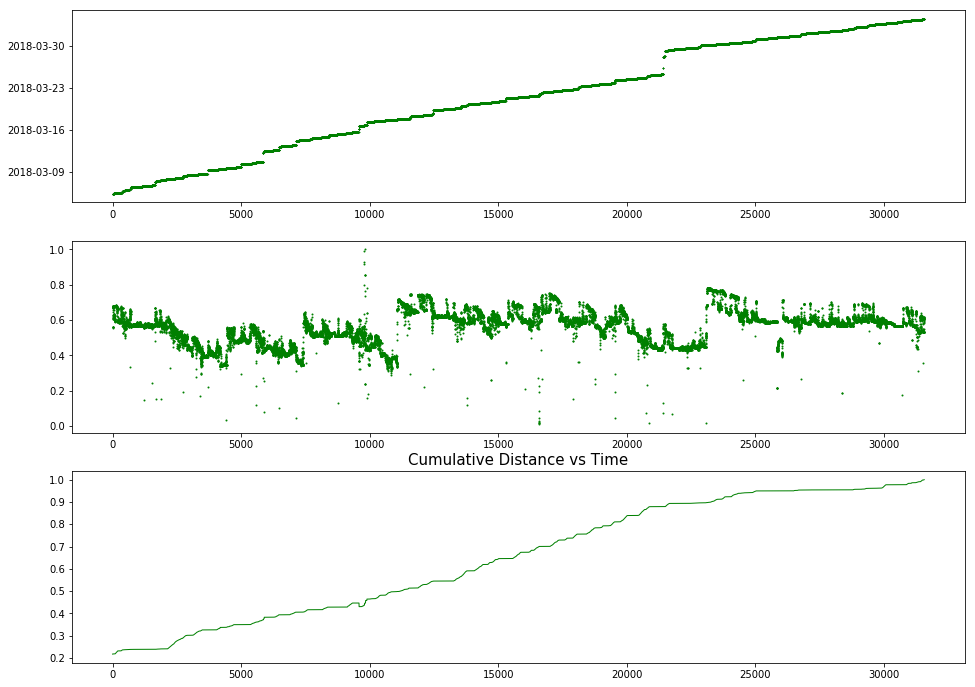

In [8]:
plotData_profiles(dff)

In [9]:
dff.fuelVoltage.mean()

0.5598114667487583

In [10]:
dff.fuelVoltage.std()

0.09180351782232254

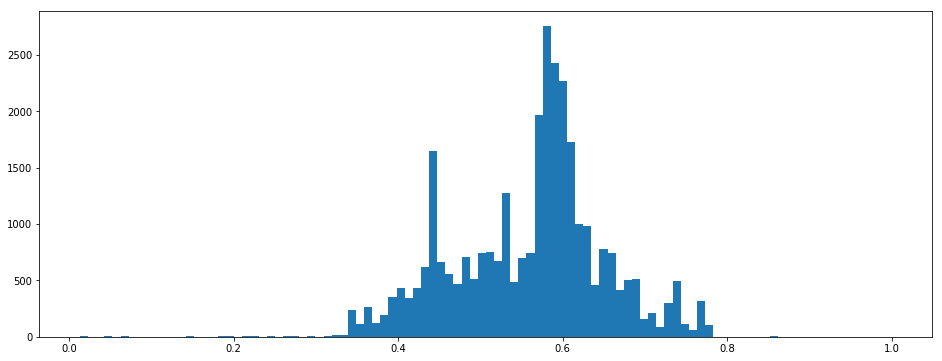

In [11]:
plt.rcParams['figure.figsize'] = [16,6]
plt.hist(dff.fuelVoltage,100);
#plt.xlim(0,0.02)
#plt.ylim(0,2.5)

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


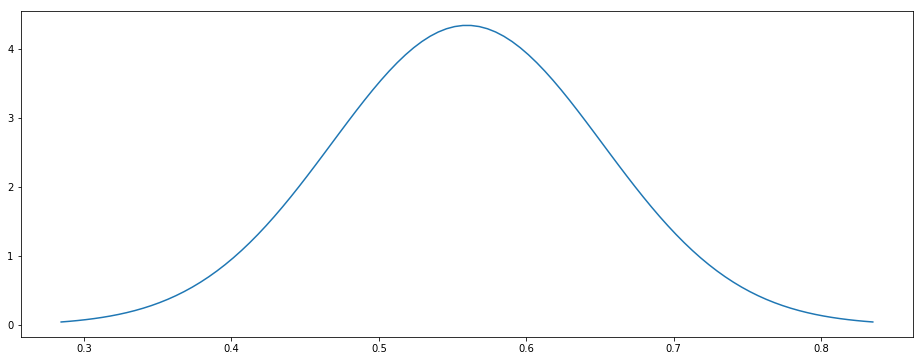

In [12]:
import matplotlib.mlab as mlab
mu = dff.fuelVoltage.mean()
#variance = (dff.fuelVoltage.std())*(dff.fuelVoltage.std())
sigma = dff.fuelVoltage.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))

In [13]:
dff[(dff.fuelVoltage == 0)  & (dff.dev_state == 1)]

,datetime,lat,long,speed,distance,fuelVoltage,dev_state


In [14]:
df_clean = cleanDF(dff.copy())

Dataset_1 Data Cleaning Done


In [15]:
theft_pts = findtheft(df_clean)

**
36
Dataset_1 Theft points Indentified


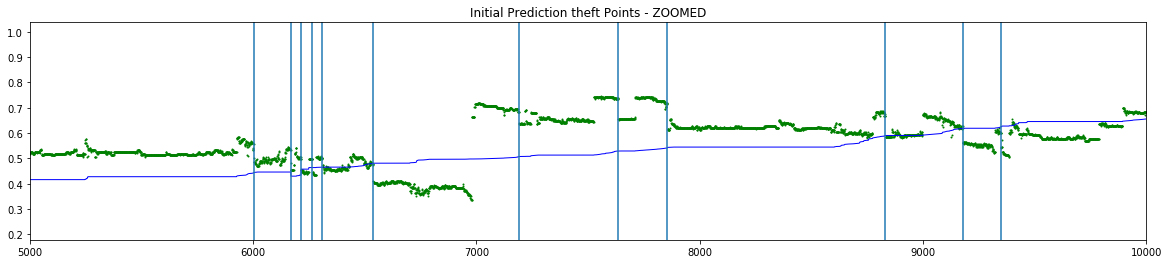

36


In [16]:
xlim = [5000,10000]
ylim = []
plot_theftpts(df_clean,theft_pts, xlim = xlim, ylim= ylim)
result_df = dc.generate_PredictTable(df_clean,theft_pts,float(Dmax), fuelMax)

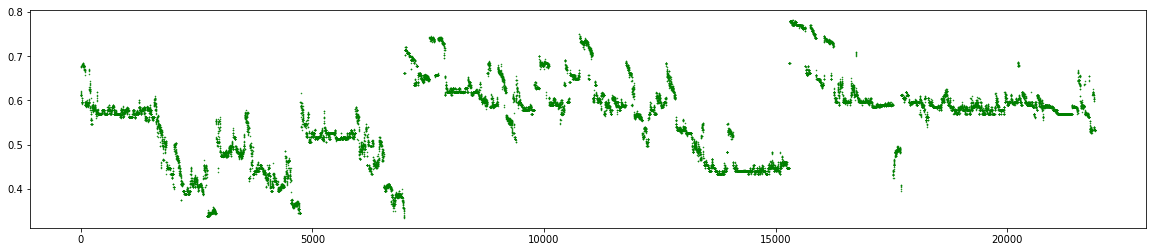

In [17]:
plt.plot(df_clean.index, df_clean.fuelVoltage,'g.', markersize = 1);

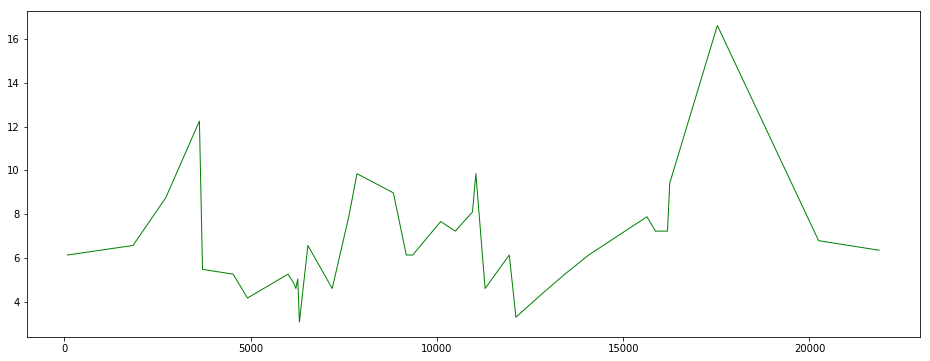

In [18]:
plt.rcParams['figure.figsize'] = [16,6]
plt.plot(result_df.theft_index, result_df['fuel_jump'], 'g-', markersize=3, linewidth=1);
#plt.ylim(0,400)

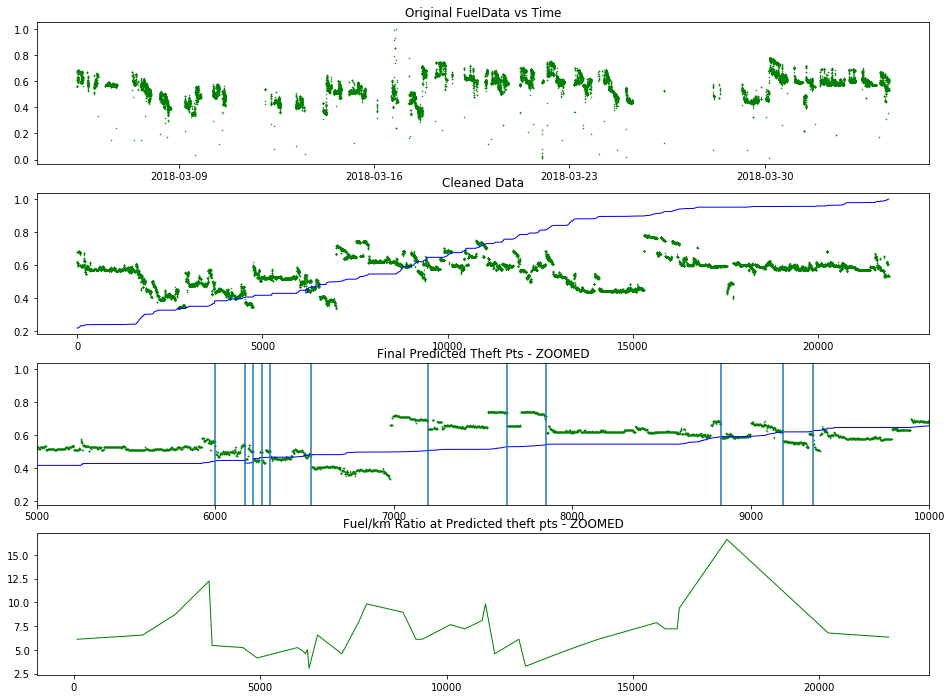

    theft_index         lat        long          theft_time  fuel_jump  dist_jump(KM)       time_jump  Possibility     FuelPerKM
0            86  24.2898833  80.7682267 2018-03-05 11:35:13   6.126915   7.883869e-07 0 days 00:10:49         True  7.771457e+06
1          1844    25.13026    80.44252 2018-03-08 09:03:55   6.564551   1.795372e-07 0 days 00:06:32         True  3.656374e+07
2          2724  24.8454133   80.268735 2018-03-09 09:32:42   8.752735   3.440951e-06 0 days 01:30:00         True  2.543697e+06
3          3626    24.89713  80.2850267 2018-03-10 10:15:57  12.253829   1.175055e-06 0 days 03:52:40         True  1.042830e+07
4          3709  24.7379617  80.2722683 2018-03-10 16:05:54   5.470460   4.623173e-06 1 days 15:17:21         True  1.183270e+06
5          4531   24.906395  80.2646567 2018-03-13 10:19:07   5.251641   1.472850e-07 0 days 01:10:35         True  3.565632e+07
6          4916    24.73842  80.2721633 2018-03-14 10:58:56   4.157549   2.150146e-08 0 days 02:2

In [19]:
#build_savePath = savePath + r"\result_dataset_" + filesname[ctr].replace(folderpath,"").replace('\\', "")
#result_df.to_csv(build_savePath)

plot_Results(dff,df_clean,result_df, xlim = xlim, ylim=ylim)
#ctr+=1
print(result_df)

In [20]:
def findAVG(cleanDf, Dmax):
    i = 0
    ds = 0
    df = 0
    dsRef = 0
    avgDT = []
    dt = 100
    mean_lst = []
    median_lst = []
    mode_lst = []
    ctr = 0
    print(Dmax)
    while dt < Dmax:
        avgDT = []
        #print (dt)
        i=0
        while i<len(cleanDf): 
            ds = 0
            dsRef = cleanDf.distance[i]
            dfRef = cleanDf.fuelVoltage[i]
            while ((ds)<=dt  and i<len(cleanDf)):
                ds = (cleanDf.distance[i] - dsRef)*float(Dmax)
                i+=1
                #print(i)

            if i<len(cleanDf):
                df = dfRef- cleanDf.fuelVoltage[i]
                if df>0 :
                    avg = df
                    avgDT.append(avg)
            #print(df)
        med = pd.Series(avgDT).median()
        mean = pd.Series(avgDT).mean()
        mode = pd.Series(avgDT).mode()
        #print (med,mean,mode)

        median_lst.append(med)
        mean_lst.append(mean)
        mode_lst.append(mode)
        ctr+=1
        dt += ctr*100
        print (dt)

        
    return pd.Series(avgDT), [median_lst,mean_lst,mode_lst]

avgDT, central_DT = findAVG(df_clean, Dmax)

1.0


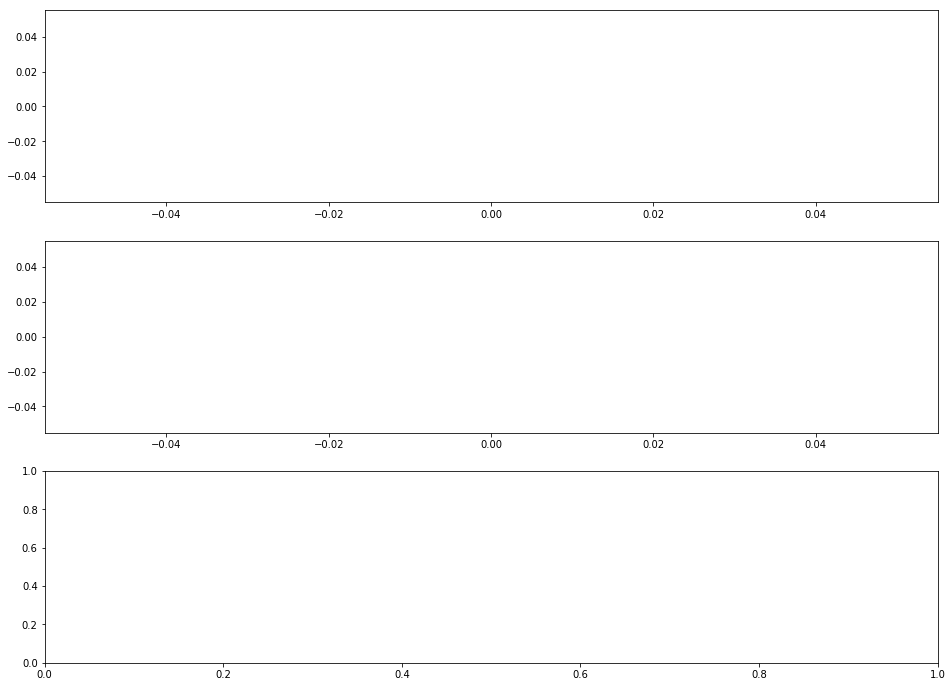

In [21]:
#dt = [i*100 for (i,dt) in zip(len(central_DT[0]),Dmax) ]
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.plot(central_DT[0]);
plt.subplot(3,1,2)
plt.plot(central_DT[1]);
plt.subplot(3,1,3)
#plt.plot(central_DT[2]);

        

In [ ]:
(central_DT[0])

In [ ]:
plt.hist(avgDT[abs(avgDT - avgDT.mean()) < 3*avgDT.std()],bins = 200)
plt.axvline(avgDT.median(), color = 'black')
plt.axvline(avgDT.mean(), color = 'green')

In [ ]:
a = avgDT.value_counts()
avgDT.median(), avgDT.mean(), avgDT.mode()

10km:
mean = 0.0167
median = 0.0131
mode = 0.0037

1km:
mean = 0.0095
median = 0.00562
mode = 0.00187

5km:
mean = 0.00138
median = 0.00936
mode = 0.00187

0.5Km
mean = 0.00138
median = 0.00936
mode = 0.00187

50km
mean = 0.0373
median = 0.0365
mode = 0.0411

100km
mean = 0.065988
median = 0.0692
mode = 0.048689









In [ ]:
plt.plot(df_clean.distance * .001*Dmax, df_clean.fuelVoltage,  'g.')